# let's try to implement a conv decoder

only using the last head

## part 1: stat the dataset

In [1]:
import h5py
from matplotlib import pyplot as plt
import einops
import math

In [2]:
fp = h5py.File('voc_projection.h5', 'r')
fp.keys()

<KeysViewHDF5 ['train.encodings', 'train.features', 'train.labels', 'trainval.encodings', 'trainval.features', 'trainval.labels', 'val.encodings', 'val.features', 'val.labels']>

In [3]:
train_encodings = fp['train.encodings']
train_features  = fp['train.features']
train_labels    = fp['train.labels']

print('train labels:   ', train_labels.shape)
print('train features: ', train_features.shape)
print('train encodings:', train_encodings.shape)

train labels:    (1464, 224, 224)
train features:  (1464, 3, 224, 224)
train encodings: (1464, 256, 1280)


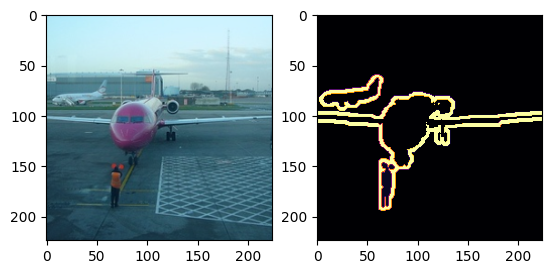

In [4]:
fig, (ax_img, ax_lbl) = plt.subplots(1, 2)

image = einops.rearrange(train_features[0], 'c h w -> h w c')
image = (image + abs(image.min())) / abs(image.max() - image.min()) # undo the preprocessing for display

ax_img.imshow(image)
ax_lbl.imshow(train_labels[0], cmap='inferno')
plt.show()

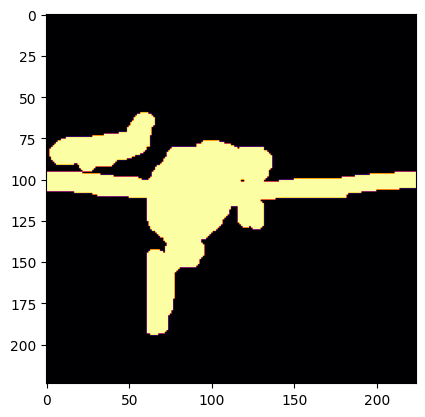

In [5]:
y_test = train_labels[0].copy()
y_test[y_test > 0] = 1.0
plt.imshow(y_test, cmap='inferno')

## part 2: a dataset loader

(repeating imports for easier splitting into files)

In [6]:
import h5py
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from typing import Any
import numpy as np
import einops

class ToTensor:
    '''Convert ndarrays to tensors.'''

    def __call__(self, arr):
        return torch.from_numpy(arr)

    
class ScaleToUnit:
    '''convert a label to 0-1 from 0-255'''
    def __call__(self, label):
        # this was dumb:
        # return (label + abs(label.min())) / abs(label.max() - label.min())
        return label / 255.0
    
class OneHotTwoClassLabelMatrix:
    '''Convert label ndarrays (NxM) to (NxMx2) one-hot encoded vectors'''

    def __call__(self, label):
        # assumes noclass is 0 and class is 1
        return np.stack(
            [
                1 - label,
                label
            ],
            axis=2
        )

class PredictEntireObject:
    '''Modify the label to fill in the label'''

    def __call__(self, label):
        # assumes noclass is 0 and class is 1
        label[label > 0] = 1.0
        return label
    
    
class VOCProjectedDataset(Dataset):
    projection_dataset_file: Path
    projection_split: str
    dataset_handle: Any
    transform: Any
    target_transform: Any
    
    labels: np.ndarray
    encodings: np.ndarray

    def __init__(self, projection_set: Path, split: str = 'training', transform=None, target_transform=None):
        '''
        Load a dataset from the voc projected h5 file
        '''
        if type(projection_set) is str:
            projection_set = Path(projection_set)
        assert projection_set.exists()

        # save the transform & dataset info
        self.transform = transform
        self.target_transform = target_transform
        self.projection_dataset_file = projection_set
        self.projection_split = split

        # open the dataset and do some sanity checks
        self.dataset_handle = h5py.File(self.projection_dataset_file, 'r')

        # i regret not using h5's groups for this
        # c'est la vie
        assert f'{split}.encodings' in self.dataset_handle
        assert f'{split}.labels' in self.dataset_handle
        assert self.dataset_handle[f'{split}.encodings'].shape[0] == self.dataset_handle[f'{split}.labels'].shape[0]
        
        self.labels = self.dataset_handle[f'{split}.labels']
        self.encodings = self.dataset_handle[f'{split}.encodings']
        
    def __len__(self):
        return self.labels.shape[0]


    def __getitem__(self, index):
        X = self.encodings[index]
        y = self.labels[index]
        
        if self.transform:
            X = self.transform(X)
        
        if self.target_transform:
            y = self.target_transform(y)
            
        return X, y
    

dataset = VOCProjectedDataset(
    'voc_projection.h5',
    split='train',
    transform=ToTensor(),
    target_transform=Compose([
        ScaleToUnit(),
        OneHotTwoClassLabelMatrix(),
        ToTensor()
    ])
)
print(f'voc dataset on {dataset.projection_split} contains {len(dataset)} elements')


voc dataset on train contains 1464 elements


## part 3: a really simple decoder

In [7]:

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class ConvolutionalDecoder(nn.Module):
#     def __init__(self):
#         super(ConvolutionalDecoder, self).__init__()
    
#         # ngl this is a super big guess
#         self.conv1 = nn.ConvTranspose2d(1280, 256, kernel_size=11, stride=2, padding=2)
#         self.bn1 = nn.BatchNorm2d(256)
#         self.conv2 = nn.ConvTranspose2d(256, 1, kernel_size=9, stride=6, padding=3, output_padding=5)
#         self.bn2 = nn.BatchNorm2d(1)
    
#     def forward(self, x):
#         # first, convert the (batch) x 256 (heads) x 1280 (head depth) latent rep to Bx1280x16x16
#         x = einops.rearrange(x, 'b (h1 h2) d -> b d h1 h2', h1 = 16)
        
#         # conv block 1 : 1280x16x16 -> 256x37x37
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = F.relu(x)
#         # conv block 2 :  256x37x37 -> 2x224x224
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = F.sigmoid(x)
        
#         return x

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch
from torch import nn

class OneHeadConvolutionalDecoder(nn.Module):
    def __init__(self):
        super(OneHeadConvolutionalDecoder, self).__init__()
        self.decoder = nn.Sequential(
            # Begin with a linear layer to map latent vector to a spatial structure
            nn.Linear(1280, 256 * 7 * 7),  # Adjust size according to desired feature map size
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),  # Reshape to (batch_size, channels, height, width)
            
            # Transposed convolutional layers
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 56, 56)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 112, 112)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 224, 224)
            nn.Sigmoid()  # Assuming output pixel values are to be between 0 and 1
        )

    def forward(self, x):
        x = x[:,-1,:] # get the last head's rep
        return self.decoder(x)

# test    
model = OneHeadConvolutionalDecoder()
model(torch.rand(8,256,1280))

tensor([[[[0.4968, 0.4806, 0.4780,  ..., 0.4606, 0.4782, 0.4928],
          [0.5215, 0.4056, 0.5042,  ..., 0.5567, 0.4446, 0.5072],
          [0.4993, 0.4333, 0.5352,  ..., 0.4516, 0.4185, 0.4747],
          ...,
          [0.4949, 0.4234, 0.4308,  ..., 0.4514, 0.5156, 0.4826],
          [0.4529, 0.4190, 0.5455,  ..., 0.3935, 0.5646, 0.4319],
          [0.5222, 0.4606, 0.5556,  ..., 0.4807, 0.5084, 0.4999]]],


        [[[0.4999, 0.4802, 0.4810,  ..., 0.4732, 0.4809, 0.4915],
          [0.5272, 0.4178, 0.4880,  ..., 0.4993, 0.3991, 0.5086],
          [0.4982, 0.4266, 0.5192,  ..., 0.4210, 0.4718, 0.4634],
          ...,
          [0.4901, 0.4377, 0.4458,  ..., 0.4910, 0.5480, 0.4859],
          [0.4618, 0.4205, 0.5227,  ..., 0.3736, 0.5907, 0.4420],
          [0.5236, 0.4558, 0.5590,  ..., 0.4815, 0.5019, 0.4987]]],


        [[[0.5032, 0.4812, 0.4773,  ..., 0.4698, 0.4733, 0.4975],
          [0.5348, 0.4134, 0.5121,  ..., 0.4987, 0.4231, 0.5062],
          [0.4782, 0.3960, 0.5268,  ..

# part the fourth: can we actually get this thing to train?

In [9]:
%%time

# hyperparams
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 256
FINAL_MODEL_CKPT = './checkpoints/decoder_onehead_epoch255.pth'
FINAL_MODEL_METRICS = './checkpoints/decoder_onehead_metrics.npy'

# setup
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import einops
from torchmetrics import JaccardIndex
import statistics
from pathlib import Path

def train():
    dataset_train = VOCProjectedDataset(
        'voc_projection.h5',
        split='train',
        transform=ToTensor(),
        target_transform=Compose([
            ScaleToUnit(),
            PredictEntireObject(),
            # OneHotTwoClassLabelMatrix(),
            ToTensor()
        ])
    )
    dataset_val = VOCProjectedDataset(
        'voc_projection.h5',
        split='trainval',
        transform=ToTensor(),
        target_transform=Compose([
            ScaleToUnit(),
            PredictEntireObject(),
            # OneHotTwoClassLabelMatrix(),
            ToTensor()
        ])
    )

    dl_train = DataLoader(
        dataset_train,
        pin_memory=True,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=12
    )
    dl_val = DataLoader(
        dataset_val,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        num_workers=12
    )

    device = 'cuda'
    # device = 'cpu'

    model = OneHeadConvolutionalDecoder().to(device)

    # loss_fn = torch.nn.BCELoss()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE
    )


    # we're gonna make a metrics matrix
    # EPOCH x (trn loss, trn jac, tst jac)
    metrics = np.zeros((EPOCHS, 3))


    # pbar = trange(EPOCHS, desc='epoch')
    for epoch in range(EPOCHS):
        # print(f'training epoch {epoch}/{EPOCHS}...')

        model.train()
        avg_trn_loss = []
        avg_trn_jaccard = []
        jaccard = JaccardIndex(
            task='binary'
        ).to(device)
        for X, y in tqdm(dl_train, desc='train'):

            # running into some weird numerical issue with CUDA... this didn't fix it.
            # X = torch.clamp(X, min=0, max=1)
            # y = torch.clamp(y, min=0, max=1)

            X = X.to(device)

            # y = einops.rearrange(y, 'b h w c -> b c h w')
            y = y.to(device)


            output = model(X)
            # output = output

            loss = loss_fn(output.squeeze(), y)
            loss.backward()
            optimizer.step()

            loss_val = loss.item()
            # print(loss_val)
            with torch.no_grad():
                # print('output shape', output.shape)
                # print('y shape', y.shape)

                # okay, here we're going to do something cursed
                # we'll clamp everything > 0 

                y_jac = y.clone().detach()
                y_jac[y_jac > 0.5] = 1
                y_jac[y_jac != 1]  = 0

                out_jac = output.clone().detach()

                jaccard_val = jaccard(out_jac.flatten(), y_jac.flatten())
                jaccard_val = jaccard_val.cpu().numpy() # unwrap the 0-dim tensor
                jaccard_val = float(jaccard_val)

                avg_trn_loss.append(loss_val)
            avg_trn_jaccard.append(jaccard_val)

        avg_trn_loss = statistics.mean(avg_trn_loss)
        avg_trn_jaccard = statistics.mean(avg_trn_jaccard)
        # avg_trn_jaccard = None


        # break

        avg_tst_jaccard = []

        model.eval()
        with torch.no_grad():
            for X, y in tqdm(dl_val, desc='val'):
                X = X.to(device)
                y = y.to(device)

                output = model(X)
                y_jac = y.clone().detach()
                y_jac[y_jac > 0.5] = 1
                y_jac[y_jac != 1]  = 0

                out_jac = output.clone().detach()

                jaccard_val = jaccard(out_jac.flatten(), y_jac.flatten())
                jaccard_val = jaccard_val.cpu().numpy() # unwrap the 0-dim tensor
                jaccard_val = float(jaccard_val)

                avg_tst_jaccard.append(jaccard_val)

        avg_tst_jaccard = statistics.mean(avg_tst_jaccard)


        print(f'epoch {epoch}: train loss {avg_trn_loss:0.4}, train jaccard: {avg_trn_jaccard:0.4}, test jaccard: {avg_tst_jaccard:0.4}')

        metrics[epoch] = (avg_trn_loss, avg_trn_jaccard, avg_tst_jaccard)

        torch.save(
            model.state_dict(),
            f'./checkpoints/decoder_fullobj_epoch{epoch}.pth'
        )
    
    return model, metrics

if Path(FINAL_MODEL_CKPT).exists():
    model = OneHeadConvolutionalDecoder()
    model.load_state_dict(
        torch.load(FINAL_MODEL_CKPT)
    )
    metrics = np.load(FINAL_MODEL_METRICS)
    print(f'loaded model from checkpoint ({FINAL_MODEL_CKPT})')
    
else:
    print(f'no model checkpoint found, beginning train...')
    model, metrics = train()
    np.save(FINAL_MODEL_METRICS, metrics)


no model checkpoint found, beginning train...


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.11it/s]


epoch 0: train loss 479.2, train jaccard: 0.3926, test jaccard: 0.4511


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.23it/s]


epoch 1: train loss 475.8, train jaccard: 0.4324, test jaccard: 0.4478


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.34it/s]


epoch 2: train loss 474.5, train jaccard: 0.4587, test jaccard: 0.4699


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.78it/s]


epoch 3: train loss 474.2, train jaccard: 0.4686, test jaccard: 0.4719


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.70it/s]


epoch 4: train loss 473.5, train jaccard: 0.4665, test jaccard: 0.4617


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.12it/s]


epoch 5: train loss 473.0, train jaccard: 0.4817, test jaccard: 0.4839


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.56it/s]


epoch 6: train loss 473.7, train jaccard: 0.4842, test jaccard: 0.4855


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.69it/s]


epoch 7: train loss 472.1, train jaccard: 0.4861, test jaccard: 0.4895


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.64it/s]


epoch 8: train loss 472.5, train jaccard: 0.496, test jaccard: 0.4924


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.32it/s]


epoch 9: train loss 472.3, train jaccard: 0.5047, test jaccard: 0.4995


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.13it/s]


epoch 10: train loss 471.5, train jaccard: 0.5141, test jaccard: 0.5054


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.00it/s]


epoch 11: train loss 471.6, train jaccard: 0.5154, test jaccard: 0.5055


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.96it/s]


epoch 12: train loss 471.2, train jaccard: 0.52, test jaccard: 0.5083


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.78it/s]


epoch 13: train loss 471.6, train jaccard: 0.5186, test jaccard: 0.5042


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.14it/s]


epoch 14: train loss 470.6, train jaccard: 0.5177, test jaccard: 0.5041


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.31it/s]


epoch 15: train loss 470.2, train jaccard: 0.5176, test jaccard: 0.503


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.79it/s]


epoch 16: train loss 470.2, train jaccard: 0.523, test jaccard: 0.5133


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.72it/s]


epoch 17: train loss 470.1, train jaccard: 0.5343, test jaccard: 0.5166


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.72it/s]


epoch 18: train loss 469.7, train jaccard: 0.5362, test jaccard: 0.5161


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.39it/s]


epoch 19: train loss 469.9, train jaccard: 0.5378, test jaccard: 0.5194


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.54it/s]


epoch 20: train loss 469.8, train jaccard: 0.5431, test jaccard: 0.522


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.39it/s]


epoch 21: train loss 469.6, train jaccard: 0.544, test jaccard: 0.5236


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.44it/s]


epoch 22: train loss 469.6, train jaccard: 0.5484, test jaccard: 0.5271


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.52it/s]


epoch 23: train loss 468.8, train jaccard: 0.5475, test jaccard: 0.5225


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.88it/s]


epoch 24: train loss 469.4, train jaccard: 0.5441, test jaccard: 0.52


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.34it/s]


epoch 25: train loss 468.1, train jaccard: 0.543, test jaccard: 0.5206


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.90it/s]


epoch 26: train loss 468.9, train jaccard: 0.5472, test jaccard: 0.5225


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.87it/s]


epoch 27: train loss 469.2, train jaccard: 0.5483, test jaccard: 0.5238


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.42it/s]


epoch 28: train loss 469.6, train jaccard: 0.552, test jaccard: 0.5278


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.68it/s]


epoch 29: train loss 468.9, train jaccard: 0.5586, test jaccard: 0.532


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.47it/s]


epoch 30: train loss 467.8, train jaccard: 0.5633, test jaccard: 0.5316


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.55it/s]


epoch 31: train loss 469.1, train jaccard: 0.5646, test jaccard: 0.531


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.43it/s]


epoch 32: train loss 468.3, train jaccard: 0.5657, test jaccard: 0.5339


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.09it/s]


epoch 33: train loss 468.1, train jaccard: 0.5719, test jaccard: 0.537


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.59it/s]


epoch 34: train loss 468.2, train jaccard: 0.5727, test jaccard: 0.5378


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.84it/s]


epoch 35: train loss 468.5, train jaccard: 0.5734, test jaccard: 0.5421


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.80it/s]


epoch 36: train loss 467.9, train jaccard: 0.578, test jaccard: 0.5441


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.41it/s]


epoch 37: train loss 467.7, train jaccard: 0.5806, test jaccard: 0.5431


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.32it/s]


epoch 38: train loss 468.3, train jaccard: 0.5778, test jaccard: 0.5399


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.28it/s]


epoch 39: train loss 468.4, train jaccard: 0.5748, test jaccard: 0.5387


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.86it/s]


epoch 40: train loss 467.8, train jaccard: 0.574, test jaccard: 0.5384


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.56it/s]


epoch 41: train loss 467.6, train jaccard: 0.5754, test jaccard: 0.538


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.28it/s]


epoch 42: train loss 467.1, train jaccard: 0.5746, test jaccard: 0.5394


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.68it/s]


epoch 43: train loss 467.9, train jaccard: 0.5819, test jaccard: 0.5435


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.42it/s]


epoch 44: train loss 466.9, train jaccard: 0.59, test jaccard: 0.5475


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.49it/s]


epoch 45: train loss 467.3, train jaccard: 0.5971, test jaccard: 0.5489


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.71it/s]


epoch 46: train loss 467.0, train jaccard: 0.5997, test jaccard: 0.5492


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.83it/s]


epoch 47: train loss 467.6, train jaccard: 0.5985, test jaccard: 0.5498


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.43it/s]


epoch 48: train loss 467.4, train jaccard: 0.5998, test jaccard: 0.5508


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.72it/s]


epoch 49: train loss 466.8, train jaccard: 0.5941, test jaccard: 0.5514


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.14it/s]


epoch 50: train loss 466.6, train jaccard: 0.5934, test jaccard: 0.5508


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.68it/s]


epoch 51: train loss 466.7, train jaccard: 0.5945, test jaccard: 0.5518


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.43it/s]


epoch 52: train loss 467.0, train jaccard: 0.596, test jaccard: 0.5513


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.66it/s]


epoch 53: train loss 466.5, train jaccard: 0.5966, test jaccard: 0.5492


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.17it/s]


epoch 54: train loss 467.2, train jaccard: 0.5963, test jaccard: 0.5498


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.01it/s]


epoch 55: train loss 466.7, train jaccard: 0.5971, test jaccard: 0.5507


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.75it/s]


epoch 56: train loss 466.3, train jaccard: 0.6024, test jaccard: 0.5532


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.53it/s]


epoch 57: train loss 465.9, train jaccard: 0.6075, test jaccard: 0.5564


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.87it/s]


epoch 58: train loss 465.6, train jaccard: 0.6103, test jaccard: 0.559


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.57it/s]


epoch 59: train loss 466.3, train jaccard: 0.6132, test jaccard: 0.5606


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.25it/s]


epoch 60: train loss 466.6, train jaccard: 0.6119, test jaccard: 0.5606


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.84it/s]


epoch 61: train loss 466.0, train jaccard: 0.6097, test jaccard: 0.5587


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.41it/s]


epoch 62: train loss 466.3, train jaccard: 0.6104, test jaccard: 0.5589


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.49it/s]


epoch 63: train loss 466.8, train jaccard: 0.6085, test jaccard: 0.5566


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.60it/s]


epoch 64: train loss 466.5, train jaccard: 0.608, test jaccard: 0.5551


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.51it/s]


epoch 65: train loss 466.8, train jaccard: 0.6097, test jaccard: 0.5554


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.03it/s]


epoch 66: train loss 466.0, train jaccard: 0.612, test jaccard: 0.5571


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.81it/s]


epoch 67: train loss 466.7, train jaccard: 0.6159, test jaccard: 0.5596


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.06it/s]


epoch 68: train loss 466.2, train jaccard: 0.6196, test jaccard: 0.562


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.55it/s]


epoch 69: train loss 466.7, train jaccard: 0.6202, test jaccard: 0.5635


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.00it/s]


epoch 70: train loss 466.0, train jaccard: 0.6223, test jaccard: 0.5634


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.50it/s]


epoch 71: train loss 465.8, train jaccard: 0.6192, test jaccard: 0.5636


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.45it/s]


epoch 72: train loss 466.8, train jaccard: 0.6214, test jaccard: 0.5653


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.27it/s]


epoch 73: train loss 466.3, train jaccard: 0.6221, test jaccard: 0.5658


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.47it/s]


epoch 74: train loss 465.6, train jaccard: 0.6237, test jaccard: 0.5657


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.69it/s]


epoch 75: train loss 465.1, train jaccard: 0.6226, test jaccard: 0.5659


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.47it/s]


epoch 76: train loss 466.1, train jaccard: 0.6249, test jaccard: 0.5664


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.48it/s]


epoch 77: train loss 465.9, train jaccard: 0.6298, test jaccard: 0.5672


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.36it/s]


epoch 78: train loss 466.0, train jaccard: 0.6319, test jaccard: 0.5684


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.75it/s]


epoch 79: train loss 466.0, train jaccard: 0.6339, test jaccard: 0.5699


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.78it/s]


epoch 80: train loss 465.5, train jaccard: 0.6316, test jaccard: 0.5687


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.02it/s]


epoch 81: train loss 465.4, train jaccard: 0.6314, test jaccard: 0.568


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.21it/s]


epoch 82: train loss 465.1, train jaccard: 0.626, test jaccard: 0.5674


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.58it/s]


epoch 83: train loss 465.4, train jaccard: 0.6305, test jaccard: 0.568


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.97it/s]


epoch 84: train loss 466.0, train jaccard: 0.634, test jaccard: 0.5727


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.28it/s]


epoch 85: train loss 465.7, train jaccard: 0.6405, test jaccard: 0.575


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.35it/s]


epoch 86: train loss 465.1, train jaccard: 0.645, test jaccard: 0.5747


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.45it/s]


epoch 87: train loss 465.1, train jaccard: 0.6459, test jaccard: 0.5733


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.20it/s]


epoch 88: train loss 465.7, train jaccard: 0.6441, test jaccard: 0.5715


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.66it/s]


epoch 89: train loss 465.0, train jaccard: 0.6364, test jaccard: 0.5694


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.02it/s]


epoch 90: train loss 465.2, train jaccard: 0.6328, test jaccard: 0.5682


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.06it/s]


epoch 91: train loss 464.9, train jaccard: 0.6287, test jaccard: 0.5643


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.46it/s]


epoch 92: train loss 464.7, train jaccard: 0.6241, test jaccard: 0.5626


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.92it/s]


epoch 93: train loss 465.4, train jaccard: 0.6297, test jaccard: 0.5689


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.37it/s]


epoch 94: train loss 465.3, train jaccard: 0.6373, test jaccard: 0.5741


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.83it/s]


epoch 95: train loss 465.1, train jaccard: 0.6448, test jaccard: 0.5771


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.55it/s]


epoch 96: train loss 465.4, train jaccard: 0.6528, test jaccard: 0.5795


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.69it/s]


epoch 97: train loss 464.5, train jaccard: 0.6534, test jaccard: 0.5804


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.86it/s]


epoch 98: train loss 464.7, train jaccard: 0.6563, test jaccard: 0.5811


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.28it/s]


epoch 99: train loss 465.0, train jaccard: 0.6582, test jaccard: 0.5818


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.34it/s]


epoch 100: train loss 465.5, train jaccard: 0.6602, test jaccard: 0.5824


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.65it/s]


epoch 101: train loss 464.4, train jaccard: 0.6577, test jaccard: 0.5812


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.24it/s]


epoch 102: train loss 464.5, train jaccard: 0.6529, test jaccard: 0.5795


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.28it/s]


epoch 103: train loss 464.7, train jaccard: 0.6483, test jaccard: 0.5778


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.01it/s]


epoch 104: train loss 464.8, train jaccard: 0.6458, test jaccard: 0.5751


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.57it/s]


epoch 105: train loss 465.2, train jaccard: 0.6456, test jaccard: 0.5754


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.18it/s]


epoch 106: train loss 464.2, train jaccard: 0.6441, test jaccard: 0.5752


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.85it/s]


epoch 107: train loss 465.2, train jaccard: 0.6456, test jaccard: 0.577


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.40it/s]


epoch 108: train loss 465.0, train jaccard: 0.6503, test jaccard: 0.5778


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.65it/s]


epoch 109: train loss 464.7, train jaccard: 0.6534, test jaccard: 0.578


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.72it/s]


epoch 110: train loss 464.4, train jaccard: 0.6553, test jaccard: 0.5786


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.10it/s]


epoch 111: train loss 464.3, train jaccard: 0.6572, test jaccard: 0.5801


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.94it/s]


epoch 112: train loss 464.0, train jaccard: 0.6604, test jaccard: 0.5821


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.89it/s]


epoch 113: train loss 464.8, train jaccard: 0.6641, test jaccard: 0.5841


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.66it/s]


epoch 114: train loss 464.4, train jaccard: 0.6628, test jaccard: 0.5847


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.01it/s]


epoch 115: train loss 463.7, train jaccard: 0.6593, test jaccard: 0.5803


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.96it/s]


epoch 116: train loss 465.2, train jaccard: 0.6575, test jaccard: 0.5811


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.53it/s]


epoch 117: train loss 464.4, train jaccard: 0.6543, test jaccard: 0.5797


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.64it/s]


epoch 118: train loss 465.7, train jaccard: 0.651, test jaccard: 0.5818


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.92it/s]


epoch 119: train loss 464.5, train jaccard: 0.6555, test jaccard: 0.5805


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.42it/s]


epoch 120: train loss 464.2, train jaccard: 0.6563, test jaccard: 0.5804


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.32it/s]


epoch 121: train loss 464.2, train jaccard: 0.6565, test jaccard: 0.5811


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.52it/s]


epoch 122: train loss 464.3, train jaccard: 0.6567, test jaccard: 0.5813


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.44it/s]


epoch 123: train loss 463.9, train jaccard: 0.664, test jaccard: 0.5819


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.37it/s]


epoch 124: train loss 463.9, train jaccard: 0.6654, test jaccard: 0.5834


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.57it/s]


epoch 125: train loss 464.5, train jaccard: 0.6681, test jaccard: 0.5852


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.50it/s]


epoch 126: train loss 463.6, train jaccard: 0.6691, test jaccard: 0.5857


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.25it/s]


epoch 127: train loss 464.5, train jaccard: 0.6671, test jaccard: 0.5858


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.87it/s]


epoch 128: train loss 464.0, train jaccard: 0.6655, test jaccard: 0.5859


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.21it/s]


epoch 129: train loss 464.4, train jaccard: 0.6643, test jaccard: 0.5862


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.43it/s]


epoch 130: train loss 463.5, train jaccard: 0.6627, test jaccard: 0.5853


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.39it/s]


epoch 131: train loss 464.1, train jaccard: 0.6626, test jaccard: 0.5867


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.55it/s]


epoch 132: train loss 463.9, train jaccard: 0.6637, test jaccard: 0.5863


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.73it/s]


epoch 133: train loss 464.5, train jaccard: 0.666, test jaccard: 0.5863


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.20it/s]


epoch 134: train loss 463.9, train jaccard: 0.6694, test jaccard: 0.5857


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.34it/s]


epoch 135: train loss 464.0, train jaccard: 0.6674, test jaccard: 0.5851


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.29it/s]


epoch 136: train loss 464.6, train jaccard: 0.671, test jaccard: 0.5848


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.32it/s]


epoch 137: train loss 463.9, train jaccard: 0.6721, test jaccard: 0.5852


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.22it/s]


epoch 138: train loss 464.0, train jaccard: 0.672, test jaccard: 0.5864


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.69it/s]


epoch 139: train loss 464.2, train jaccard: 0.6729, test jaccard: 0.5872


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.47it/s]


epoch 140: train loss 463.8, train jaccard: 0.6743, test jaccard: 0.5874


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.18it/s]


epoch 141: train loss 463.9, train jaccard: 0.6711, test jaccard: 0.5875


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.50it/s]


epoch 142: train loss 463.9, train jaccard: 0.6667, test jaccard: 0.5857


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.27it/s]


epoch 143: train loss 464.4, train jaccard: 0.6653, test jaccard: 0.5849


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.07it/s]


epoch 144: train loss 464.1, train jaccard: 0.6678, test jaccard: 0.5883


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.28it/s]


epoch 145: train loss 463.6, train jaccard: 0.6693, test jaccard: 0.5898


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.65it/s]


epoch 146: train loss 463.5, train jaccard: 0.675, test jaccard: 0.5895


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.74it/s]


epoch 147: train loss 463.4, train jaccard: 0.6795, test jaccard: 0.5908


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.42it/s]


epoch 148: train loss 464.1, train jaccard: 0.6826, test jaccard: 0.5912


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.98it/s]


epoch 149: train loss 463.8, train jaccard: 0.6836, test jaccard: 0.5906


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.31it/s]


epoch 150: train loss 463.8, train jaccard: 0.6839, test jaccard: 0.5909


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.67it/s]


epoch 151: train loss 463.9, train jaccard: 0.6838, test jaccard: 0.5917


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.10it/s]


epoch 152: train loss 463.0, train jaccard: 0.6839, test jaccard: 0.5923


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.55it/s]


epoch 153: train loss 463.6, train jaccard: 0.6819, test jaccard: 0.5934


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.44it/s]


epoch 154: train loss 463.4, train jaccard: 0.6781, test jaccard: 0.5925


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.17it/s]


epoch 155: train loss 463.2, train jaccard: 0.6755, test jaccard: 0.591


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.51it/s]


epoch 156: train loss 464.2, train jaccard: 0.6745, test jaccard: 0.5911


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.71it/s]


epoch 157: train loss 463.5, train jaccard: 0.6715, test jaccard: 0.5898


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.32it/s]


epoch 158: train loss 464.2, train jaccard: 0.6752, test jaccard: 0.5916


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.37it/s]


epoch 159: train loss 464.1, train jaccard: 0.6773, test jaccard: 0.5927


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.62it/s]


epoch 160: train loss 464.0, train jaccard: 0.6809, test jaccard: 0.5935


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.56it/s]


epoch 161: train loss 463.1, train jaccard: 0.6851, test jaccard: 0.594


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.39it/s]


epoch 162: train loss 463.3, train jaccard: 0.6883, test jaccard: 0.5941


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.62it/s]


epoch 163: train loss 463.1, train jaccard: 0.6896, test jaccard: 0.593


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.04it/s]


epoch 164: train loss 463.4, train jaccard: 0.6888, test jaccard: 0.5921


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.43it/s]


epoch 165: train loss 463.4, train jaccard: 0.6883, test jaccard: 0.5918


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.44it/s]


epoch 166: train loss 463.2, train jaccard: 0.6903, test jaccard: 0.5924


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.38it/s]


epoch 167: train loss 463.5, train jaccard: 0.6906, test jaccard: 0.5937


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.09it/s]


epoch 168: train loss 463.5, train jaccard: 0.689, test jaccard: 0.595


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.55it/s]


epoch 169: train loss 463.6, train jaccard: 0.6873, test jaccard: 0.5951


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.49it/s]


epoch 170: train loss 463.6, train jaccard: 0.6847, test jaccard: 0.596


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.35it/s]


epoch 171: train loss 463.3, train jaccard: 0.6857, test jaccard: 0.5954


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.07it/s]


epoch 172: train loss 463.5, train jaccard: 0.6833, test jaccard: 0.5956


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.61it/s]


epoch 173: train loss 463.5, train jaccard: 0.6825, test jaccard: 0.5945


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.89it/s]


epoch 174: train loss 462.9, train jaccard: 0.6825, test jaccard: 0.5928


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.14it/s]


epoch 175: train loss 463.8, train jaccard: 0.6833, test jaccard: 0.5943


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.78it/s]


epoch 176: train loss 464.3, train jaccard: 0.6837, test jaccard: 0.596


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.34it/s]


epoch 177: train loss 463.3, train jaccard: 0.6858, test jaccard: 0.5953


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.32it/s]


epoch 178: train loss 463.5, train jaccard: 0.6883, test jaccard: 0.5948


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.15it/s]


epoch 179: train loss 463.5, train jaccard: 0.6905, test jaccard: 0.5968


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.52it/s]


epoch 180: train loss 463.7, train jaccard: 0.6937, test jaccard: 0.5977


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.20it/s]


epoch 181: train loss 463.6, train jaccard: 0.6937, test jaccard: 0.5981


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.36it/s]


epoch 182: train loss 463.1, train jaccard: 0.6977, test jaccard: 0.5979


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.36it/s]


epoch 183: train loss 463.1, train jaccard: 0.6973, test jaccard: 0.5984


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.98it/s]


epoch 184: train loss 463.8, train jaccard: 0.6973, test jaccard: 0.5989


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.25it/s]


epoch 185: train loss 463.4, train jaccard: 0.7009, test jaccard: 0.5991


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.80it/s]


epoch 186: train loss 463.6, train jaccard: 0.6984, test jaccard: 0.5993


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.07it/s]


epoch 187: train loss 463.3, train jaccard: 0.6975, test jaccard: 0.5992


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.09it/s]


epoch 188: train loss 463.1, train jaccard: 0.7, test jaccard: 0.6


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.73it/s]


epoch 189: train loss 462.8, train jaccard: 0.6979, test jaccard: 0.5991


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.55it/s]


epoch 190: train loss 463.4, train jaccard: 0.6985, test jaccard: 0.5991


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.25it/s]


epoch 191: train loss 463.4, train jaccard: 0.6972, test jaccard: 0.5993


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.92it/s]


epoch 192: train loss 463.1, train jaccard: 0.6967, test jaccard: 0.5979


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.07it/s]


epoch 193: train loss 463.5, train jaccard: 0.6953, test jaccard: 0.5959


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.44it/s]


epoch 194: train loss 463.8, train jaccard: 0.6884, test jaccard: 0.5969


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.32it/s]


epoch 195: train loss 463.4, train jaccard: 0.6917, test jaccard: 0.5957


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.84it/s]


epoch 196: train loss 463.0, train jaccard: 0.6905, test jaccard: 0.5939


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.46it/s]


epoch 197: train loss 463.5, train jaccard: 0.6912, test jaccard: 0.5965


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.10it/s]


epoch 198: train loss 463.4, train jaccard: 0.6922, test jaccard: 0.5985


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.35it/s]


epoch 199: train loss 463.0, train jaccard: 0.6951, test jaccard: 0.5983


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.43it/s]


epoch 200: train loss 463.2, train jaccard: 0.6983, test jaccard: 0.5995


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.33it/s]


epoch 201: train loss 463.1, train jaccard: 0.699, test jaccard: 0.6013


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.45it/s]


epoch 202: train loss 462.6, train jaccard: 0.7039, test jaccard: 0.6012


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.56it/s]


epoch 203: train loss 463.4, train jaccard: 0.7046, test jaccard: 0.603


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.86it/s]


epoch 204: train loss 463.1, train jaccard: 0.7049, test jaccard: 0.6039


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.51it/s]


epoch 205: train loss 463.2, train jaccard: 0.7058, test jaccard: 0.6044


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.09it/s]


epoch 206: train loss 462.3, train jaccard: 0.7057, test jaccard: 0.603


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.21it/s]


epoch 207: train loss 462.4, train jaccard: 0.7062, test jaccard: 0.6035


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.14it/s]


epoch 208: train loss 462.4, train jaccard: 0.7066, test jaccard: 0.6029


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.87it/s]


epoch 209: train loss 463.7, train jaccard: 0.7064, test jaccard: 0.603


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.64it/s]


epoch 210: train loss 462.4, train jaccard: 0.7047, test jaccard: 0.6002


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.99it/s]


epoch 211: train loss 462.8, train jaccard: 0.7038, test jaccard: 0.6002


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.47it/s]


epoch 212: train loss 463.3, train jaccard: 0.7012, test jaccard: 0.5989


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.55it/s]


epoch 213: train loss 463.4, train jaccard: 0.6989, test jaccard: 0.5999


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.51it/s]


epoch 214: train loss 463.2, train jaccard: 0.6977, test jaccard: 0.5976


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.48it/s]


epoch 215: train loss 462.9, train jaccard: 0.6973, test jaccard: 0.5994


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.38it/s]


epoch 216: train loss 462.8, train jaccard: 0.697, test jaccard: 0.5983


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.37it/s]


epoch 217: train loss 462.5, train jaccard: 0.7, test jaccard: 0.5986


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.75it/s]


epoch 218: train loss 462.9, train jaccard: 0.6984, test jaccard: 0.5999


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.09it/s]


epoch 219: train loss 463.2, train jaccard: 0.7005, test jaccard: 0.6013


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.44it/s]


epoch 220: train loss 462.7, train jaccard: 0.7041, test jaccard: 0.6023


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.57it/s]


epoch 221: train loss 462.9, train jaccard: 0.7078, test jaccard: 0.6037


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.29it/s]


epoch 222: train loss 462.8, train jaccard: 0.7101, test jaccard: 0.6046


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.99it/s]


epoch 223: train loss 462.7, train jaccard: 0.7106, test jaccard: 0.6036


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.34it/s]


epoch 224: train loss 462.7, train jaccard: 0.7146, test jaccard: 0.6052


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.45it/s]


epoch 225: train loss 462.3, train jaccard: 0.7154, test jaccard: 0.6049


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.38it/s]


epoch 226: train loss 462.7, train jaccard: 0.7141, test jaccard: 0.6051


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.02it/s]


epoch 227: train loss 462.8, train jaccard: 0.7124, test jaccard: 0.6052


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.07it/s]


epoch 228: train loss 463.2, train jaccard: 0.7133, test jaccard: 0.605


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.29it/s]


epoch 229: train loss 463.2, train jaccard: 0.7113, test jaccard: 0.6038


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.42it/s]


epoch 230: train loss 462.6, train jaccard: 0.7068, test jaccard: 0.6016


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.21it/s]


epoch 231: train loss 462.4, train jaccard: 0.7067, test jaccard: 0.6022


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.21it/s]


epoch 232: train loss 462.6, train jaccard: 0.7031, test jaccard: 0.6028


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.46it/s]


epoch 233: train loss 462.5, train jaccard: 0.7051, test jaccard: 0.6016


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.68it/s]


epoch 234: train loss 463.3, train jaccard: 0.706, test jaccard: 0.604


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.44it/s]


epoch 235: train loss 462.1, train jaccard: 0.7063, test jaccard: 0.6028


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 36.23it/s]


epoch 236: train loss 463.3, train jaccard: 0.7088, test jaccard: 0.605


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.01it/s]


epoch 237: train loss 462.4, train jaccard: 0.7118, test jaccard: 0.6048


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 34.94it/s]


epoch 238: train loss 463.2, train jaccard: 0.7126, test jaccard: 0.6058


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.29it/s]


epoch 239: train loss 462.5, train jaccard: 0.7159, test jaccard: 0.6067


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.53it/s]


epoch 240: train loss 462.2, train jaccard: 0.7174, test jaccard: 0.6061


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.15it/s]


epoch 241: train loss 462.6, train jaccard: 0.7163, test jaccard: 0.6066


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.42it/s]


epoch 242: train loss 463.1, train jaccard: 0.7166, test jaccard: 0.6071


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.62it/s]


epoch 243: train loss 462.8, train jaccard: 0.7134, test jaccard: 0.6054


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.30it/s]


epoch 244: train loss 462.4, train jaccard: 0.7128, test jaccard: 0.604


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.26it/s]


epoch 245: train loss 462.3, train jaccard: 0.71, test jaccard: 0.6039


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.36it/s]


epoch 246: train loss 462.6, train jaccard: 0.7077, test jaccard: 0.604


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.13it/s]


epoch 247: train loss 462.8, train jaccard: 0.7089, test jaccard: 0.6033


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.26it/s]


epoch 248: train loss 462.3, train jaccard: 0.7087, test jaccard: 0.6017


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.35it/s]


epoch 249: train loss 462.3, train jaccard: 0.7092, test jaccard: 0.6033


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.38it/s]


epoch 250: train loss 461.8, train jaccard: 0.7117, test jaccard: 0.6034


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.17it/s]


epoch 251: train loss 462.7, train jaccard: 0.7138, test jaccard: 0.6043


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.16it/s]


epoch 252: train loss 462.2, train jaccard: 0.7164, test jaccard: 0.6049


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.19it/s]


epoch 253: train loss 461.8, train jaccard: 0.7189, test jaccard: 0.6057


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.53it/s]


epoch 254: train loss 463.3, train jaccard: 0.7192, test jaccard: 0.6068


val: 100%|█████████████████████████████████| 92/92 [00:02<00:00, 35.81it/s]


epoch 255: train loss 462.3, train jaccard: 0.7187, test jaccard: 0.607
CPU times: user 12min 51s, sys: 8min 42s, total: 21min 33s
Wall time: 17min 54s


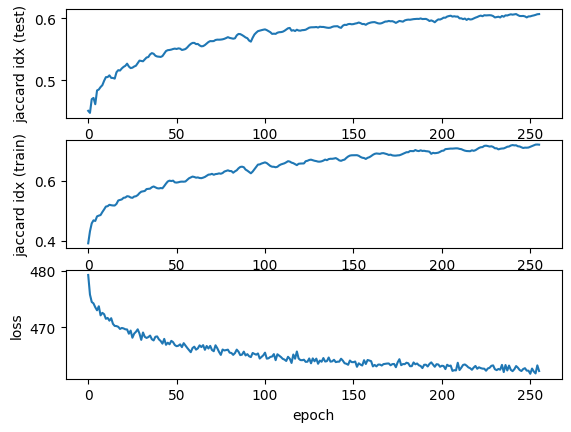

In [10]:
fig, (ax_jac_tst, ax_jac_trn, ax_loss) = plt.subplots(3)

# jaccard axis (tst)
ax_jac_tst.set_xlabel('epoch')
ax_jac_tst.set_ylabel('jaccard idx (test)')
ax_jac_tst.plot(np.arange(0,metrics.shape[0]), metrics[:,2])

# jaccard axis (trn)
ax_jac_trn.set_xlabel('epoch')
ax_jac_trn.set_ylabel('jaccard idx (train)')
ax_jac_trn.plot(np.arange(0,metrics.shape[0]), metrics[:,1])

# loss (trn)
ax_loss.set_xlabel('epoch')
ax_loss.set_ylabel('loss')
ax_loss.plot(np.arange(0,metrics.shape[0]), metrics[:,0])

torch.Size([1, 256, 1280])


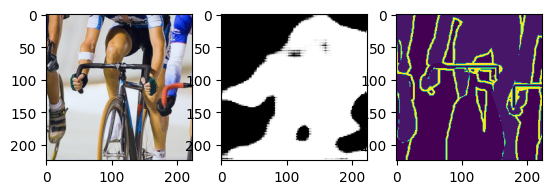

In [25]:
def show_val_sample(index):
    dataset_trnval = VOCProjectedDataset(
        'voc_projection.h5',
        split='val',
        transform=ToTensor(),
        target_transform=Compose([
            ScaleToUnit(),
            # OneHotTwoClassLabelMatrix(),
            ToTensor()
        ])
    )



    def create_pred(model, feature_pair, device = 'cuda'):
        X, y = feature_pair

        model = model.to(device)
        X, y = X.to(device), y.to(device)

        X = X[None, :, :]
        
        model.eval()
        with torch.no_grad():
            print(X.shape)
            output = model(X)

        return output.cpu().numpy()


    X, y = dataset_trnval[index]
    feat = dataset_trnval.dataset_handle['val.features'][index]
    output = create_pred(model, (X,y))[0,0,:,:]

    fig, (ax_feat, ax_pred, ax_true) = plt.subplots(1,3)

    X_image = einops.rearrange(feat, 'c h w -> h w c')
    X_image = (X_image + abs(X_image.min())) / abs(X_image.max() - X_image.min()) # undo the preprocessing for display

    ax_feat.imshow(X_image)
    ax_pred.imshow(output, cmap='gray')
    ax_true.imshow(y)
        
show_val_sample(4)